# COLIEE 2024 Dataset Exploration


In [2]:
from pathlib import Path
import json, random, textwrap
import pandas as pd
import re, itertools

In [5]:
# Use Training Dataset or Test dataset 
# DATASET_DIR  = Path("Test/Dataset")
# LABELS_FILE  = DATASET_DIR / "task1_test_labels_2025.json"
# CASES_DIR    = DATASET_DIR / "cases"

DATASET_DIR  = Path("Training/Dataset")
LABELS_FILE  = DATASET_DIR / "clean_task1_train_labels_2026.json"
CASES_DIR    = DATASET_DIR / "cases"

## 1.  Basic paths – edit here only if your folder names differ


In [6]:


assert LABELS_FILE.exists(),  "Labels file not found – check your path"
assert CASES_DIR.exists(),    "Cases directory not found – check your path"

## 2.  Load labels → tidy DataFrame


In [7]:
with LABELS_FILE.open(encoding="utf-8") as f:
    raw_labels = json.load(f)

records = [
    {"query_id": q, "num_citations": len(supp), "citations": supp}
    for q, supp in raw_labels.items()
]
labels_df = pd.DataFrame(records).sort_values("query_id").reset_index(drop=True)

print(f"Loaded {len(labels_df):,} query cases")
display(labels_df.head())

Loaded 2,001 query cases


,query_id,num_citations,citations
0,000002.txt,3,"[040679.txt, 066809.txt, 030947.txt]"
1,000031.txt,8,"[087019.txt, 011771.txt, 082701.txt, 091216.tx..."
2,000068.txt,9,"[051517.txt, 030257.txt, 004969.txt, 017411.tx..."
3,000085.txt,3,"[047032.txt, 038007.txt, 061172.txt]"
4,000092.txt,7,"[007418.txt, 085296.txt, 093174.txt, 040661.tx..."


In [8]:
# Quick count of all query–candidate pairs
total_pairs = int(labels_df["num_citations"].sum())
print(f"Total query–candidate pairs: {total_pairs:,}")

# Optional: make a flat (query_id, candidate_id) table
pairs_df = (
    labels_df[["query_id", "citations"]]
    .explode("citations", ignore_index=True)
    .rename(columns={"citations": "candidate_id"})
    .dropna()
    .drop_duplicates()
)

# Sanity check for your example
ex = "000068.txt"
if ex in labels_df["query_id"].values:
    n = pairs_df.query("query_id == @ex").shape[0]
    print(f"{ex} -> {n} query–candidate pairs")

# peek
pairs_df.head()


Total query–candidate pairs: 8,251
000068.txt -> 9 query–candidate pairs


,query_id,candidate_id
0,000002.txt,040679.txt
1,000002.txt,066809.txt
2,000002.txt,030947.txt
3,000031.txt,087019.txt
4,000031.txt,011771.txt


## Quick summary statistics


In [9]:
print("\n--- Label statistics ----------------------------------")
print(labels_df["num_citations"].describe())


--- Label statistics ----------------------------------
count    2001.000000
mean        4.123438
std         3.494604
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        34.000000
Name: num_citations, dtype: float64


In [10]:
from collections import Counter
import pandas as pd

# Flatten the list of all cited cases
all_cited_cases = list(itertools.chain.from_iterable(labels_df["citations"]))

# Count each citation's frequency
citation_counts = Counter(all_cited_cases)

# Convert to DataFrame for inspection/sorting
citation_df = pd.DataFrame(citation_counts.items(), columns=["case_id", "count"])
citation_df = citation_df.sort_values("count", ascending=False).reset_index(drop=True)

print(f"\nTotal unique cited cases: {len(citation_df):,}")
display(citation_df.head(10))  # top 10 most-cited cases

display(citation_df.tail(10))  # top 10 most-cited cases



Total unique cited cases: 5,857


,case_id,count
0,000749.txt,44
1,038112.txt,26
2,023998.txt,21
3,067036.txt,18
4,008545.txt,14
5,034646.txt,13
6,007925.txt,13
7,065661.txt,13
8,017936.txt,13
9,007589.txt,13


,case_id,count
5847,026752.txt,1
5848,050180.txt,1
5849,051371.txt,1
5850,076221.txt,1
5851,043418.txt,1
5852,071594.txt,1
5853,047555.txt,1
5854,097291.txt,1
5855,034677.txt,1
5856,064582.txt,1


In [11]:
# 1. Get set of query IDs (strip .txt if needed)
query_ids = set(labels_df["query_id"])

# 2. Get set of cited case IDs
cited_ids = set(citation_df["case_id"])

# 3. Union of all used case IDs
used_case_ids = query_ids.union(cited_ids)

# 4. List all .txt files in the CASES_DIR
all_case_files = {p.name for p in CASES_DIR.glob("*.txt")}

# 5. Find unused files (not in labels or citations)
unused_cases = all_case_files - used_case_ids

# Show results
print(f"\nTotal case files on disk: {len(all_case_files):,}")
print(f"Cases used in labels (query or cited): {len(used_case_ids):,}")
print(f"Unused cases (not referenced in labels): {len(unused_cases):,}")
print("\nSample of unused cases:")
display(list(sorted(unused_cases))[:10])



Total case files on disk: 7,708
Cases used in labels (query or cited): 7,547
Unused cases (not referenced in labels): 161

Sample of unused cases:


['000430.txt',
 '001540.txt',
 '002768.txt',
 '003243.txt',
 '003821.txt',
 '004037.txt',
 '004633.txt',
 '005147.txt',
 '005505.txt',
 '005869.txt']

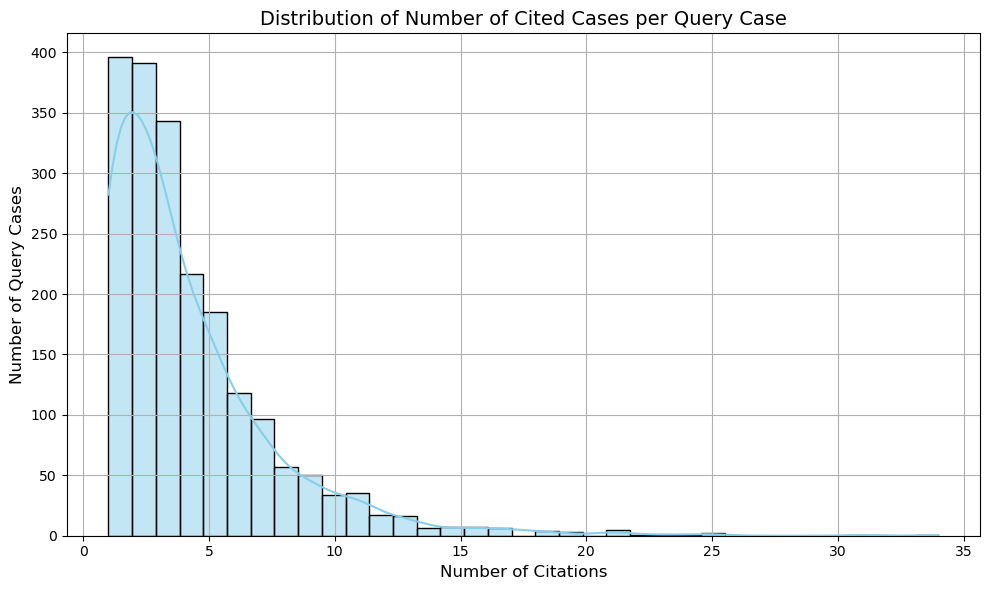

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic setup
plt.figure(figsize=(10, 6))
sns.histplot(labels_df["num_citations"], bins=35, kde=True, color="skyblue", edgecolor="black")

# Titles and labels
plt.title("Distribution of Number of Cited Cases per Query Case", fontsize=14)
plt.xlabel("Number of Citations", fontsize=12)
plt.ylabel("Number of Query Cases", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


## 3.  Tiny helpers to read / preview case files


In [13]:
def read_case(doc_id: str) -> str:
    """Return full text of a single COLIEE case (UTF-8)."""
    p = CASES_DIR / doc_id
    if not p.exists():
        raise FileNotFoundError(p)
    return p.read_text(encoding="utf-8", errors="ignore")

def preview_case(doc_id: str, lines: int = 25):
    """Pretty-print the first N lines of a case file."""
    txt = read_case(doc_id)
    snippet = "\n".join(txt.splitlines()[:lines])
    print("="*80, f"\n{doc_id}  (first {lines} lines)\n", "="*80)
    print(snippet)

# Example: look at the first query document
preview_case(labels_df.loc[0, "query_id"], 50)

000002.txt  (first 50 lines)
[1]
Bédard, J.
[Translation]: This is an application for judicial review under subsection 72(1) of the
Immigration and Refugee Protection
Act
, S.C. 2001, c. 27 (the
Act
), of a decision of the Immigration Appeal Division of the Immigration and Refugee Board of Canada (the IAD), dated February 5, 2010, dismissing the applicant's appeal of a decision of the immigration officer of the Canadian Embassy in Abidjan, rejecting his application for permanent residence under the family class for the Cameroonian applicant's three adoptive children.
Background
[2]
The applicant is a Canadian citizen from Cameroon. On October 16, 2006, by a judgment of the court of first instance in Douala, he adopted, through a process of simple adoption, the three children of his friend who had died in 2003. The three children were born to two different mothers.
[3]
On April 2008, the applicant took steps to sponsor and obtain visas for the three children for permanent residence in C

## 4.  Lightweight keyword / regex search over the corpus


In [14]:
def search(keyword: str, max_hits: int = 10, regex=False):
    """
    Return list of (doc_id, line_no, line_text) for the first max_hits matches.
    Set regex=True to interpret the keyword as a regular expression.
    """
    pattern = re.compile(keyword if regex else re.escape(keyword), re.I)
    hits = []
    for txt_path in itertools.islice(CASES_DIR.glob("*.txt"), None):
        for i, line in enumerate(txt_path.open(encoding="utf-8", errors="ignore")):
            if pattern.search(line):
                hits.append((txt_path.name, i+1, line.strip()))
                if len(hits) >= max_hits:
                    return hits
    return hits

# Example: find “procedural fairness” mentions
for doc, ln, line in search("procedural fairness", max_hits=5):
    print(f"{doc:>12} : {ln:>4} | {textwrap.shorten(line, 80)}")

  000002.txt :   37 | 1) Did the IAD breach the duty of procedural fairness by not holding a [...]
  000002.txt :   44 | The first issue is one of procedural fairness and must be reviewed [...]
  000002.txt :   77 | <FRAGMENT_SUPPRESSED> ; 2008 FC 655, the Court wrote that there was no [...]
  000028.txt :   16 | Admission - Visitors - Temporary employment authorization visa and work [...]
  000028.txt :   19 | Admission - Visitors - Temporary employment authorization visa and work [...]


## 5.  Random visual sanity-check – peek at 3 query/support sets


In [15]:
for _, row in labels_df.sample(3, random_state=42).iterrows():
    print("\n","="*100)
    print(f"QUERY: {row.query_id}  →  {row.num_citations} cited cases")
    print("Citations:", ", ".join(row.citations))
    print("- Preview of query case:")
    preview_case(row.query_id, lines=12)


QUERY: 066334.txt  →  1 cited cases
Citations: 046857.txt
- Preview of query case:
066334.txt  (first 12 lines)
[1]
Tremblay-Lamer, J.
[Translation]: The court has before it an application for judicial review from a decision by the Refugee Division ("the panel") which found that the applicants were not Convention refugees.
Facts
[2]
The applicants Boris Fedosov, his mother Ninal Kadenko, his wife Mila Fedosov and their son Alexander Fedosov are all citizens of Israel.
[3]
As appears from the personal information form, the applicants were born in Kiev in the Ukraine and are Christians. Mila Fedosov's father was a Jew and her mother Ukrainian. On account of the terror and chaos caused in the U.S.S.R. by nationalism and discrimination, the applicants immigrated to Israel on November 6, 1990.
[4]
Once they were in Israel, the applicants alleged that the situation was no better. They related the following incidents.
[5]
Around January 1991, religious fanatics burst into their home several 

Processing cases: 100%|██████████| 7708/7708 [00:17<00:00, 451.86it/s]


--- Case File Statistics Summary ---


,num_words,num_sentences,avg_sentence_length,vocab_size
count,7708.000000,7708.000000,7708.000000,7708.000000
mean,4747.403607,206.881941,23.090045,1026.862610
std,5029.122300,231.144170,4.688549,580.987478
min,109.000000,10.000000,9.909091,75.000000
25%,2191.000000,99.000000,19.797682,657.000000
50%,3578.500000,155.000000,22.920122,909.000000
75%,5639.750000,238.000000,25.993751,1240.000000
max,113337.000000,5149.000000,47.784314,7483.000000


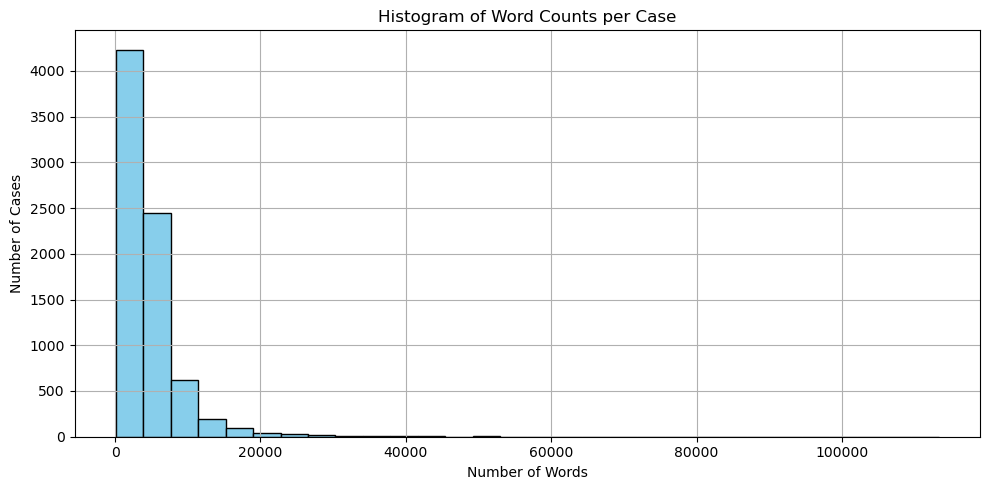

In [16]:
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

def get_case_statistics(case_dir: Path, max_files=None):
    stats = []
    file_list = list(case_dir.iterdir())
    if max_files:
        file_list = file_list[:max_files]
    
    for path in tqdm(file_list, desc="Processing cases"):
        text = path.read_text(encoding="utf-8", errors="ignore")
        words = re.findall(r"\b\w+\b", text)
        sentences = re.split(r"[.!?]\s+", text)
        paragraphs = text.split("\n\n")
        
        stats.append({
            "doc_id": path.name,
            "num_words": len(words),
            "num_sentences": len(sentences),
            #"num_paragraphs": len(paragraphs),
            "avg_sentence_length": len(words)/len(sentences) if sentences else 0,
            "vocab_size": len(set(words)),
        })
    
    return pd.DataFrame(stats)

# Run on all (or set max_files=N for faster preview)
case_stats_df = get_case_statistics(CASES_DIR)

# Summary statistics
print("\n--- Case File Statistics Summary ---")
display(case_stats_df.describe())

# Plot histogram of word counts
plt.figure(figsize=(10, 5))
plt.hist(case_stats_df["num_words"], bins=30, color="skyblue", edgecolor="black")
plt.title("Histogram of Word Counts per Case")
plt.xlabel("Number of Words")
plt.ylabel("Number of Cases")
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
print("\nLongest cases:")
display(case_stats_df.sort_values("num_words", ascending=False).head(3))

print("\nShortest cases:")
display(case_stats_df.sort_values("num_words", ascending=True).head(3))



Longest cases:


,doc_id,num_words,num_sentences,avg_sentence_length,vocab_size
4797,057368.txt,113337,5007,22.635710,7483
1260,014338.txt,110763,4696,23.586670,6910
6361,078607.txt,92643,5149,17.992426,6739



Shortest cases:


,doc_id,num_words,num_sentences,avg_sentence_length,vocab_size
6122,075466.txt,109,11,9.909091,75
3878,044952.txt,142,11,12.909091,100
2942,033670.txt,228,16,14.250000,138


In [21]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Path to the processed JSON
JSON_FILE = Path("Dataset-Clean/processed_cases.json")

# Load JSON content
with JSON_FILE.open(encoding="utf-8") as f:
    cases = json.load(f)

# Extract paragraph-level statistics
records = []
for case in tqdm(cases, desc="Analyzing cases"):
    paragraphs = case.get("paragraphs", [])
    para_lengths = [len(p.split()) for p in paragraphs]
    para_char_lengths = [len(p) for p in paragraphs]

    records.append({
        "case_id": case["case_id"],
        "num_paragraphs": len(paragraphs),
        "avg_words_per_paragraph": sum(para_lengths)/len(paragraphs) if paragraphs else 0,
        "avg_chars_per_paragraph": sum(para_char_lengths)/len(paragraphs) if paragraphs else 0,
        "total_words": sum(para_lengths),
        "total_chars": sum(para_char_lengths),
    })

df_stats = pd.DataFrame(records)

# Summary
print("\n--- Paragraph Statistics Summary ---")
display(df_stats.describe())

# Histograms
plt.figure(figsize=(12, 5))
sns.histplot(df_stats["num_paragraphs"], bins=30, kde=False)
plt.title("Histogram of Paragraph Counts per Case")
plt.xlabel("Number of Paragraphs")
plt.ylabel("Number of Cases")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df_stats["avg_words_per_paragraph"], bins=30, kde=True)
plt.title("Average Words per Paragraph")
plt.xlabel("Words per Paragraph")
plt.ylabel("Cases")
plt.grid(True)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Dataset-Clean/processed_cases.json'

In [18]:
print("\nTop 5 cases with most paragraphs:")
display(df_stats.sort_values("num_paragraphs", ascending=False).head())

print("\nTop 5 cases with fewest paragraphs:")
display(df_stats.sort_values("num_paragraphs", ascending=True).head())



Top 5 cases with most paragraphs:


NameError: name 'df_stats' is not defined